In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
# from imgaug import augmenters as iaa
import skimage.transform
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 10

### Load dataset info

In [3]:
path_to_train = '/projectnb/dl-course/jxtang/EC500_proj/train/'
data = pd.read_csv('/projectnb/dl-course/jxtang/EC500_proj/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [4]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

### Create datagenerator

In [5]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = skimage.transform.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug


### Show data

In [6]:
# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument = False)

min: 0.0, max: 1.0


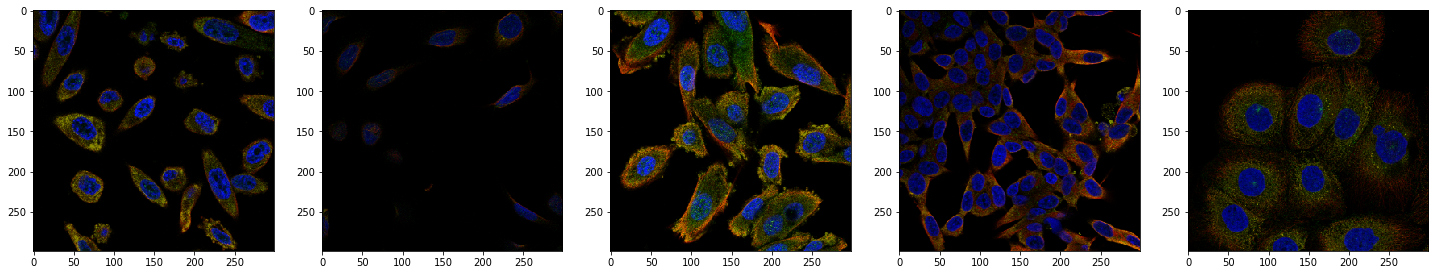

In [7]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

Using TensorFlow backend.


In [9]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [10]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [11]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

# model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Train model

In [18]:
checkpointer = ModelCheckpoint(
    './InceptionResNetV2.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=15, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/15
100/100 [==============================] - 139s - loss: 0.1728 - acc: 0.9425 - f1: 0.0433 - val_loss: 0.1815 - val_acc: 0.9420 - val_f1: 0.0453
Epoch 2/15
100/100 [==============================] - 45s - loss: 0.1775 - acc: 0.9406 - f1: 0.0461 - val_loss: 0.1800 - val_acc: 0.9431 - val_f1: 0.0446
Epoch 3/15
100/100 [==============================] - 44s - loss: 0.1792 - acc: 0.9403 - f1: 0.0456 - val_loss: 0.1801 - val_acc: 0.9425 - val_f1: 0.0445
Epoch 4/15
100/100 [==============================] - 44s - loss: 0.1728 - acc: 0.9412 - f1: 0.0451 - val_loss: 0.1812 - val_acc: 0.9407 - val_f1: 0.0452
Epoch 5/15
100/100 [==============================] - 44s - loss: 0.1751 - acc: 0.9416 - f1: 0.0451 - val_loss: 0.1806 - val_acc: 0.9418 - val_f1: 0.0449
Epoch 6/15
100/100 [==============================] - 45s - loss: 0.1761 - acc: 0.9415 - f1: 0.0438 - val_loss: 0.1797 - val_acc: 0.9425 - val_f1: 0.0443
Epoch 7/15
100/100 [==============================] - 44s - loss: 0.1753 - 

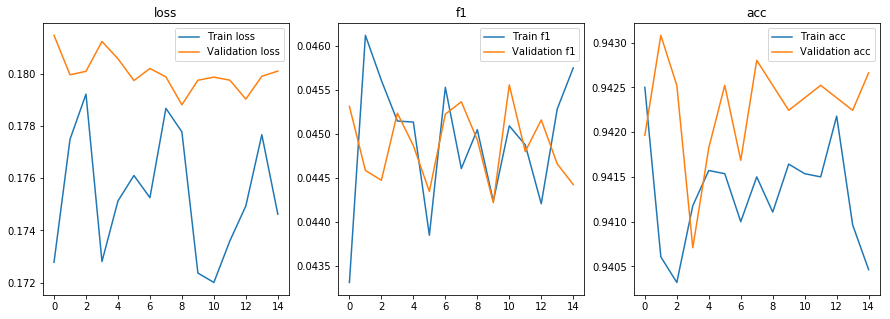

In [19]:
show_history(history)

In [20]:
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = True

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-4),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=180, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/180
100/100 [==============================] - 185s - loss: 0.1736 - acc: 0.9418 - f1: 0.0434 - val_loss: 0.1828 - val_acc: 0.9411 - val_f1: 0.0430
Epoch 2/180
100/100 [==============================] - 77s - loss: 0.1771 - acc: 0.9407 - f1: 0.0447 - val_loss: 0.1757 - val_acc: 0.9417 - val_f1: 0.0432
Epoch 3/180
100/100 [==============================] - 62s - loss: 0.1755 - acc: 0.9413 - f1: 0.0439 - val_loss: 0.1754 - val_acc: 0.9417 - val_f1: 0.0433
Epoch 4/180
100/100 [==============================] - 59s - loss: 0.1792 - acc: 0.9412 - f1: 0.0444 - val_loss: 0.1754 - val_acc: 0.9417 - val_f1: 0.0435
Epoch 5/180
100/100 [==============================] - 62s - loss: 0.1750 - acc: 0.9410 - f1: 0.0442 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0434
Epoch 6/180
100/100 [==============================] - 62s - loss: 0.1746 - acc: 0.9415 - f1: 0.0442 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0434
Epoch 7/180
100/100 [==============================] - 62s - loss: 0.

100/100 [==============================] - 60s - loss: 0.1782 - acc: 0.9425 - f1: 0.0434 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0434
Epoch 56/180
100/100 [==============================] - 60s - loss: 0.1772 - acc: 0.9408 - f1: 0.0445 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0435
Epoch 57/180
100/100 [==============================] - 60s - loss: 0.1738 - acc: 0.9424 - f1: 0.0433 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0431
Epoch 58/180
100/100 [==============================] - 60s - loss: 0.1702 - acc: 0.9436 - f1: 0.0425 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0429
Epoch 59/180
100/100 [==============================] - 60s - loss: 0.1729 - acc: 0.9420 - f1: 0.0434 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0429
Epoch 60/180
100/100 [==============================] - 60s - loss: 0.1750 - acc: 0.9418 - f1: 0.0434 - val_loss: 0.1752 - val_acc: 0.9417 - val_f1: 0.0430
Epoch 61/180
100/100 [==============================] - 59s - loss: 0.1759 - 

100/100 [==============================] - 60s - loss: 0.1731 - acc: 0.9416 - f1: 0.0438 - val_loss: 0.1754 - val_acc: 0.9417 - val_f1: 0.0431
Epoch 112/180
100/100 [==============================] - 60s - loss: 0.1780 - acc: 0.9410 - f1: 0.0439 - val_loss: 0.1754 - val_acc: 0.9417 - val_f1: 0.0434
Epoch 113/180
100/100 [==============================] - 60s - loss: 0.1737 - acc: 0.9416 - f1: 0.0443 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0433
Epoch 114/180
100/100 [==============================] - 60s - loss: 0.1719 - acc: 0.9402 - f1: 0.0455 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0435
Epoch 115/180
100/100 [==============================] - 60s - loss: 0.1748 - acc: 0.9421 - f1: 0.0441 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0434
Epoch 116/180
100/100 [==============================] - 60s - loss: 0.1737 - acc: 0.9425 - f1: 0.0431 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0432
Epoch 117/180
100/100 [==============================] - 60s - loss: 0.1

100/100 [==============================] - 61s - loss: 0.1718 - acc: 0.9425 - f1: 0.0438 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0431
Epoch 141/180
100/100 [==============================] - 60s - loss: 0.1757 - acc: 0.9408 - f1: 0.0440 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0433
Epoch 142/180
100/100 [==============================] - 60s - loss: 0.1759 - acc: 0.9407 - f1: 0.0448 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0436
Epoch 143/180
100/100 [==============================] - 60s - loss: 0.1757 - acc: 0.9411 - f1: 0.0448 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0435
Epoch 144/180
100/100 [==============================] - 60s - loss: 0.1731 - acc: 0.9427 - f1: 0.0434 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0433
Epoch 145/180
100/100 [==============================] - 59s - loss: 0.1728 - acc: 0.9426 - f1: 0.0436 - val_loss: 0.1753 - val_acc: 0.9417 - val_f1: 0.0430
Epoch 146/180
100/100 [==============================] - 60s - loss: 0.1

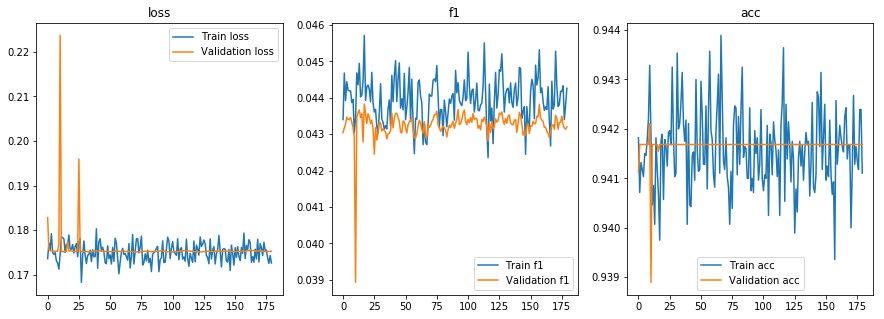

In [21]:
show_history(history)

### Create submit

In [ ]:
model = load_model(
    '/kaggle/working/InceptionResNetV2.model', 
    custom_objects={'f1': f1})

In [ ]:
submit = pd.read_csv('../input/sample_submission.csv')

In [ ]:
%%time
predicted = []
for name in tqdm(submit['Id']):
    path = os.path.join('../input/test/', name)
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

In [ ]:
submit['Predicted'] = predicted
submit.to_csv('submission.csv', index=False)